#### 生成filtered data，训练集因为做了一次异常值筛选，所以不是每一天的数据都有全部24小时的航行状态
#### 这里我们将保全24小时的日期提取出来，将没有全部24小时的日期删除

In [17]:
import pandas as pd

# 读取CSV文件
file_path = '/workspaces/SFP/Training_data/data_13_17_1_std.csv'  # 请替换为你的CSV文件路径
df = pd.read_csv(file_path)

# 将 'postime' 列解析为日期时间格式
df['postime'] = pd.to_datetime(df['postime'], format='%Y-%m-%d %H:%M:%S')

# 提取日期和小时
df['date'] = df['postime'].dt.date
df['hour'] = df['postime'].dt.hour

# 初始化一个空的 DataFrame 用于存储结果
filtered_df = pd.DataFrame()

# 按 num（船编号）分组
for num, group in df.groupby('num'):
    # 检查每个日期是否包含完整的 0-23 小时
    complete_dates = group.groupby('date')['hour'].apply(lambda x: len(set(x)) == 24 and set(x) == set(range(24)))
    valid_dates = complete_dates[complete_dates].index  # 提取满足条件的日期

    # 筛选出完整日期的数据
    filtered_group = group[group['date'].isin(valid_dates)]

    # 将筛选后的数据添加到结果 DataFrame
    filtered_df = pd.concat([filtered_df, filtered_group], ignore_index=True)

# 删除辅助列
filtered_df = filtered_df.drop(columns=['date', 'hour'])

# 保存结果为新的CSV文件
output_file = '/workspaces/SFP/validation_data/filtered_data.csv'
filtered_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"过滤后的数据已保存到: {output_file}")


过滤后的数据已保存到: /workspaces/SFP/validation_data/filtered_data.csv


## 选取船舶号码为1-3号的所有日期作为验证集，一共54天的数据

In [1]:

import pandas as pd
# 读取 CSV 文件
file_path = '/workspaces/SFP/validation_data/filtered_data.csv'  # 替换为你的 CSV 文件路径
df = pd.read_csv(file_path)


# 筛选 num 列为 1、2、3 的行
filtered_df = df[df["num"].isin([1, 2, 3])]

# 保存到新文件（如 filtered_num_123.csv）
filtered_df.to_csv("/workspaces/SFP/validation_data/validation_data.csv", index=True)  # 保留原始索引

# Validation for fuel consumption

In [1]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from class_calm_water_resistance_estimatoin import *


def Rtotal2Pe(row):
    """"

    每一行反算R_total函数

    
    """
    cu = row['stream_val']*np.sin(np.deg2rad(row['stream_direction']))
    cv = row['stream_val']*np.cos(np.deg2rad(row['stream_direction']))
    sog = row['SOG']*0.5144 # knot to m/s
    r_total = row['R_t_pre']
    heading_ship = row['heading']
    V_water = speedGPS2Water(sog, heading_ship, cu, cv) 
    Pe = V_water*r_total

    return Pe # 单位千牛


def calFuelHour(row):
    etaR = 1.0 # 准确计算较复杂，但整体波动小，经验值是1-1.07或者0.98
    etaO = 0.60 # 可以算，但需要知道V_A和thruster force T的具体意义，经验值0.55-0.7
    etaS = 0.99 # 无计算公式，取经验值，0.99，0.98，0.95-0.96三种情况
    etaH = 1.1 # 要计算t, w，1-t/1-w,需要知道力和速度的关系。
    SOFC = 200 # g/kwh
    eta = etaR*etaO*etaS*etaH

    P = row['P_pre']
    fuel_hour = P/eta*SOFC/1000000

    return fuel_hour

# 读取 CSV 文件
file_path = '/workspaces/SFP/validation_data/validation_data.csv'  # 替换为你的 CSV 文件路径
df = pd.read_csv(file_path)

# 提取指定列
columns_to_use = [
    'SOG', 'heading', 'draught', 'wind_val', 'wind_direction',
    'wave_val', 'wave_direction', 'stream_val', 'stream_direction'
]
input_df = df[columns_to_use]

# 加载预训练的集成模型
with open('/workspaces/SFP/pretrained_models/ensemble_model.pkl', 'rb') as file:
    ensemble_model = pickle.load(file)

# 数据预处理（标准化）
feature_scaler = StandardScaler()
input_features_scaled = feature_scaler.fit_transform(input_df)

# 进行预测
df['R_a_pre'] = ensemble_model.predict(input_features_scaled)

# 计算 R_t_pre 列：R_a_pre 和 R_calm 的和
df['R_t_pre'] = df['R_a_pre'] + df['R_calm']

# 计算 P_pre 列
df['P_pre'] = df.apply(Rtotal2Pe, axis=1)

# 计算 P_pre 列
df['Fuel_hour'] = df.apply(calFuelHour, axis=1)

# 提取日期（去掉时间部分）
df['date'] = pd.to_datetime(df['postime']).dt.date

# 按日期汇总 Fuel_hour
# 按 num 和 date 分组计算每天的 Fuel_hour
grouped = df.groupby(['num', 'date']).agg(
    Fuel_hour=('Fuel_hour', 'sum')  # 汇总每天的 Fuel_hour
).reset_index()

# 按 num 排序，然后在每个 num 内部按日期排序
grouped = grouped.sort_values(by=['num', 'date']).reset_index(drop=True)


grouped.to_csv('/workspaces/SFP/validation_data/predicted_day.csv')
# 保存结果为新的 CSV 文件
# output_file = 'daily_fuel_hour.csv'
# daily_fuel_hour.to_csv(output_file, index=False, encoding='utf-8-sig')

# print(f"统计完成，每日的燃料消耗量已保存到: {output_file}")

# # 保存结果为新的 CSV 文件
# output_file = '/workspaces/SFP/validation_data/predicted.csv'
# df.to_csv(output_file, index=False, encoding='utf-8-sig')

# print(f"预测完成，结果已保存到: {output_file}")

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:01:59] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator VotingRegressor from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-

In [3]:
df_fuel = pd.read_csv('/workspaces/SFP/raw_data/mrv.csv')


# 确保日期格式一致
grouped['date'] = pd.to_datetime(grouped['date']).dt.date  # 保留日期部分
df_fuel['input_date'] = pd.to_datetime(df_fuel['input_date']).dt.date  # 保留日期部分

# 合并数据，按 'num' 和日期匹配
merged_df = pd.merge(
    grouped, 
    df_fuel, 
    left_on=['num', 'date'], 
    right_on=['num', 'input_date'], 
    how='inner'
)

# 删除重复的日期列，只保留一个
merged_df = merged_df.rename(columns={'date': 'merged_date', 'Fuel_hour': 'Predict_fuel'})
final_df = merged_df[['num', 'merged_date', 'Predict_fuel', 'daily_fuel_mrv']]


final_df.to_csv('/workspaces/SFP/validation_data/final_results.csv')

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import pickle
# from class_calm_water_resistance_estimatoin import *

# ---------- 保持不变的原始函数 ---------- 

def Rtotal2Pe(row):
    """"

    每一行反算R_total函数

    
    """
    cu = row['stream_val']*np.sin(np.deg2rad(row['stream_direction']))
    cv = row['stream_val']*np.cos(np.deg2rad(row['stream_direction']))
    sog = row['SOG']*0.5144 # knot to m/s
    r_total = row['R_t_pre']
    heading_ship = row['heading']
    V_water = speedGPS2Water(sog, heading_ship, cu, cv) 
    Pe = V_water*r_total

    return Pe # 单位千牛


def calFuelHour(row):
    etaR = 1.0 # 准确计算较复杂，但整体波动小，经验值是1-1.07或者0.98
    etaO = 0.60 # 可以算，但需要知道V_A和thruster force T的具体意义，经验值0.55-0.7
    etaS = 0.99 # 无计算公式，取经验值，0.99，0.98，0.95-0.96三种情况
    etaH = 1.1 # 要计算t, w，1-t/1-w,需要知道力和速度的关系。
    SOFC = 200 # g/kwh
    eta = etaR*etaO*etaS*etaH

    P = row['P_pre']
    fuel_hour = P/eta*SOFC/1000000

    return fuel_hour
def speedGPS2Water(v, heading_ship, cu, cv):
    '''
    Function to convert speed over ground into speed through water
    '''

    V_water = v - cu * np.sin(np.deg2rad(heading_ship)) - cv * np.cos(np.deg2rad(heading_ship))

    return V_water

# ---------- 新增封装函数 ----------
def evaluate_fuel_consumption(model_path, test_data_path, mrv_path='/workspaces/SFP/raw_data/mrv.csv'):
    """
    船用油耗预测评估函数
    
    参数：
    model_path : str - 预训练模型路径
    test_data_path : str - 测试集数据路径
    mrv_path : str - 真实油耗数据路径
    
    返回：
    metrics : dict - 包含5个指标的字典
    merged_df : DataFrame - 合并后的比对数据
    """
    # ------------------------- 数据加载和校验 -------------------------
    # 加载测试数据
    try:
        df = pd.read_csv(test_data_path)
        required_cols = ['num', 'postime', 'SOG', 'heading', 'R_calm',
                       'stream_val', 'stream_direction']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise KeyError(f"缺失必要列: {missing_cols}")
    except Exception as e:
        raise ValueError(f"测试数据加载错误: {str(e)}")

    # 加载模型
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
    except Exception as e:
        raise ValueError(f"模型加载失败: {str(e)}")

    # ------------------------- 模型预测流程 -------------------------
    # 特征工程
    features = df[[
        'SOG', 'heading', 'draught', 'wind_val', 'wind_direction',
        'wave_val', 'wave_direction', 'stream_val', 'stream_direction'
    ]]
    
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    
    # 预测附加阻力
    df['R_a_pre'] = model.predict(X_scaled)
    
    # 计算总阻力
    df['R_t_pre'] = df['R_a_pre'] + df['R_calm']
    
    # 计算功率预测值（使用原始函数）
    df['P_pre'] = df.apply(Rtotal2Pe, axis=1)
    
    # 计算每小时油耗（使用原始函数）
    df['Fuel_hour'] = df.apply(calFuelHour, axis=1)
    
    # ------------------------- 数据聚合 -------------------------
    # 按日期和船号汇总
    df['date'] = pd.to_datetime(df['postime']).dt.date
    grouped = df.groupby(['num', 'date']).agg(
        Predict_fuel=('Fuel_hour', 'sum')
    ).reset_index()

    # ------------------------- 合并真实数据 -------------------------
    try:
        df_fuel = pd.read_csv(mrv_path)
        df_fuel['input_date'] = pd.to_datetime(df_fuel['input_date']).dt.date
    except Exception as e:
        raise ValueError(f"MRV数据加载错误: {str(e)}")

    merged_df = pd.merge(
        grouped,
        df_fuel,
        left_on=['num', 'date'],
        right_on=['num', 'input_date'],
        how='inner'
    ).rename(columns={'date': 'merged_date'})

    if merged_df.empty:
        raise ValueError("数据合并失败：无匹配的日期或船号")

    # ------------------------- 指标计算 -------------------------
    y_true = merged_df['daily_fuel_mrv']
    y_pred = merged_df['Predict_fuel']
    
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Sample_Count': len(merged_df)
    }

    return metrics, merged_df[['num', 'merged_date', 'Predict_fuel', 'daily_fuel_mrv']]

# ------------------------- 使用示例 -------------------------
if __name__ == "__main__":
    # 示例调用
    metrics, result_df = evaluate_fuel_consumption(
        model_path="/workspaces/SFP/pretrained_models/ensemble_model.pkl",
        test_data_path="/workspaces/SFP/validation_data/validation_data.csv"
    )
    
    print("油耗预测评估指标:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
    
    print("\n前5条数据比对:")
    print(result_df.head(20))

/home/vscode/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:08:32] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VotingRegressor from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.w

油耗预测评估指标:
RMSE: 3.2604
MAE: 2.6030
R2: 0.8411
MAPE: 4.2899
Sample_Count: 55

前5条数据比对:
    num merged_date  Predict_fuel  daily_fuel_mrv
0     1  2021-09-23     66.895377           71.43
1     1  2021-09-29     64.544546           64.52
2     1  2021-10-02     61.431862           62.02
3     1  2022-05-04     65.500448           68.61
4     1  2022-07-10     53.043403           52.42
5     1  2023-03-08     59.068931           61.59
6     1  2023-06-06     59.183492           60.67
7     1  2024-02-24     51.220042           48.96
8     1  2024-03-08     61.493985           63.94
9     2  2021-04-13     53.239944           52.21
10    2  2021-05-26     58.398339           59.96
11    2  2021-07-06     93.166496           99.73
12    2  2021-08-30     52.342294           53.18
13    2  2023-03-19     50.131751           44.93
14    2  2023-04-04     51.998914           50.28
15    2  2023-04-12     55.436587           55.92
16    2  2023-05-06     56.606956           51.99
17    2  2023-

🔄 正在加载模型...
✅ 成功加载模型: benchmark_models/SVM
✅ 成功加载模型: benchmark_models/XGBoost
✅ 成功加载模型: benchmark_models/RandomForest
✅ 成功加载模型: benchmark_models/Stacking
✅ 成功加载模型: benchmark_models/NGBoost
✅ 成功加载模型: benchmark_models/LightGBM
✅ 成功加载模型: benchmark_models/Improved_XGBoost
✅ 已加载模型: 7 个

🔄 正在评估模型...
📊 benchmark_models/SVM 评估完成
📊 benchmark_models/XGBoost 评估完成
📊 benchmark_models/RandomForest 评估完成
📊 benchmark_models/Stacking 评估完成
📊 benchmark_models/NGBoost 评估完成
📊 benchmark_models/LightGBM 评估完成
📊 benchmark_models/Improved_XGBoost 评估完成

📈 最终评估结果
                               Model    RMSE     MAE      R²   样本数
6  benchmark_models/Improved_XGBoost 80.9969 65.6236  0.0061  1320
4           benchmark_models/NGBoost 85.1774 68.8497 -0.0991  1320
2      benchmark_models/RandomForest 85.2379 68.8545 -0.1007  1320
5          benchmark_models/LightGBM 85.3993 69.3106 -0.1048  1320
0               benchmark_models/SVM 85.5093 69.5442 -0.1077  1320
1           benchmark_models/XGBoost 89.9773 72.6600 -0.2

/tmp/ipykernel_2280/2316400235.py:187: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2280/2316400235.py:187: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2280/2316400235.py:187: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2280/2316400235.py:187: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/vscode/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fi

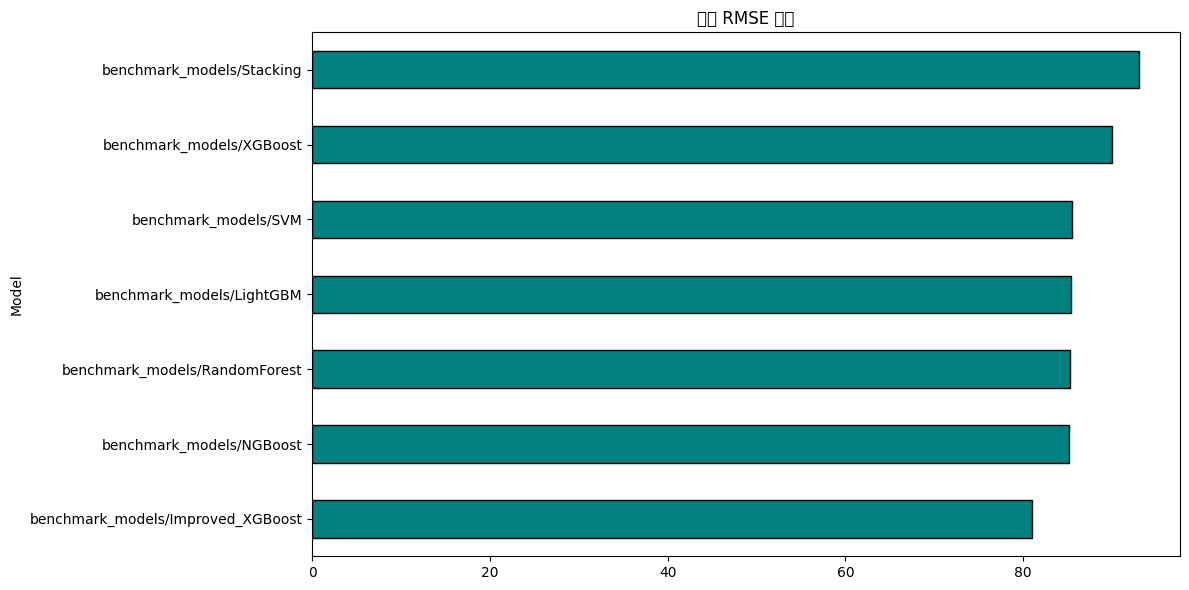

In [6]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import h2o
import matplotlib.pyplot as plt

# ==================== 全局配置 ====================
# 特征列定义（必须与训练时完全一致）
FEATURE_COLUMNS = [
    'SOG', 'heading', 'draught', 'wind_val', 'wind_direction',
    'wave_val', 'wave_direction', 'stream_val', 'stream_direction'
]

# 模型根目录
MODELS_DIR = "/workspaces/SFP/pretrained_models"

# ==================== 增强型模型加载器 ====================
class DeepModelLoader:
    """支持多级目录递归加载的模型加载器"""
    def __init__(self):
        self.models = {}  # 存储结构: { "模型路径": (模型对象, 标准化器) }

    def load_all_models(self):
        """递归加载所有子目录中的模型"""
        for root, dirs, files in os.walk(MODELS_DIR):
            # 跳过已删除的 FuzzyWSVR 目录
            if "FuzzyWSVR" in root:
                continue
                
            # 检查模型文件是否存在
            if 'model.pkl' in files and 'scaler.pkl' in files:
                model_rel_path = os.path.relpath(root, MODELS_DIR)
                try:
                    # 加载模型
                    with open(os.path.join(root, 'model.pkl'), 'rb') as f:
                        model = pickle.load(f)
                    
                    # 加载标准化器
                    with open(os.path.join(root, 'scaler.pkl'), 'rb') as f:
                        scaler = pickle.load(f)
                    
                    # 验证特征维度
                    self._validate_scaler(scaler, model_rel_path)
                    
                    self.models[model_rel_path] = (model, scaler)
                    print(f"✅ 成功加载模型: {model_rel_path}")
                    
                except Exception as e:
                    print(f"❌ 加载失败 [{model_rel_path}]: {str(e)}")
        
        # 加载 H2O 模型
        self._load_h2o_model()

    def _validate_scaler(self, scaler, model_name):
        """验证标准化器特征维度"""
        if hasattr(scaler, 'n_features_in_'):
            expected = scaler.n_features_in_
            actual = len(FEATURE_COLUMNS)
            if expected != actual:
                raise ValueError(
                    f"特征维度不匹配 - 模型 [{model_name}]\n"
                    f"训练时特征数: {expected}, 当前定义: {actual}\n"
                    f"当前特征列: {FEATURE_COLUMNS}"
                )

    def _load_h2o_model(self):
        """加载 H2O AutoML 模型"""
        h2o_dir = os.path.join(MODELS_DIR, "H2O_AutoML")
        if os.path.exists(h2o_dir):
            try:
                h2o.init()
                model = h2o.load_model(h2o_dir)
                self.models["H2O_AutoML"] = (model, None)
                print("✅ 成功加载 H2O 模型")
            except Exception as e:
                print(f"❌ 加载 H2O 模型失败: {str(e)}")

    def get_loaded_models(self):
        """获取已加载模型列表"""
        return list(self.models.keys())

# ==================== 预测评估器 ====================
class ModelEvaluator:
    def __init__(self, test_data_path):
        """
        :param test_data_path: 测试数据路径
        """
        self.test_df = self._load_and_preprocess(test_data_path)
        self.results = []

    def _load_and_preprocess(self, path):
        """加载并预处理测试数据"""
        df = pd.read_csv(path)
        
        # 删除无关列（与训练时一致）
        cols_to_drop = ['Unnamed: 0', 'Pe', 'R_total', 'R_calm', 'postime', 'num']
        df = df.drop(cols_to_drop, axis=1, errors='ignore')
        
        # 验证必要列存在
        if 'R_added' not in df.columns:
            raise KeyError("测试数据必须包含 'R_added' 列")
        missing_features = [f for f in FEATURE_COLUMNS if f not in df.columns]
        if missing_features:
            raise KeyError(f"测试数据缺少特征列: {missing_features}")
            
        return df

    def evaluate_all(self, model_loader):
        """执行全部模型评估"""
        X = self.test_df[FEATURE_COLUMNS].values
        y_true = self.test_df['R_added'].values
        
        for model_name in model_loader.models:
            model, scaler = model_loader.models[model_name]
            try:
                # H2O 特殊处理
                if model_name == "H2O_AutoML":
                    h2o_test = h2o.H2OFrame(pd.DataFrame(X, columns=FEATURE_COLUMNS))
                    y_pred = model.predict(h2o_test).as_data_frame().values.flatten()
                else:
                    # 标准化处理
                    X_scaled = scaler.transform(X)
                    y_pred = model.predict(X_scaled)
                
                # 计算指标
                self._calculate_metrics(model_name, y_true, y_pred)
                
            except Exception as e:
                print(f"⚠️ 评估失败 [{model_name}]: {str(e)}")
        
        return pd.DataFrame(self.results).sort_values("RMSE")

    def _calculate_metrics(self, model_name, y_true, y_pred):
        """计算并存储评估指标"""
        metrics = {
            "Model": model_name,
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "R²": r2_score(y_true, y_pred),
            "样本数": len(y_true)
        }
        self.results.append(metrics)
        print(f"📊 {model_name} 评估完成")

# ==================== 主程序 ====================
if __name__ == "__main__":
    # 初始化
    test_data_path = "/workspaces/SFP/validation_data/validation_data.csv"
    
    try:
        # 1. 加载模型
        print("🔄 正在加载模型...")
        loader = DeepModelLoader()
        loader.load_all_models()
        loaded_models = loader.get_loaded_models()
        
        if not loaded_models:
            raise RuntimeError("未加载任何模型，请检查：\n"
                             f"1. 模型目录是否存在: {MODELS_DIR}\n"
                             "2. 子目录是否包含 model.pkl 和 scaler.pkl")
        print(f"✅ 已加载模型: {len(loaded_models)} 个")
        
        # 2. 执行评估
        print("\n🔄 正在评估模型...")
        evaluator = ModelEvaluator(test_data_path)
        results_df = evaluator.evaluate_all(loader)
        
        # 3. 输出结果
        print("\n" + "="*40)
        print("📈 最终评估结果")
        print("="*40)
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(results_df)
        
        # 4. 可视化
        print("\n🔄 生成可视化图表...")
        plt.figure(figsize=(12, 6))
        results_df.set_index('Model')['RMSE'].sort_values().plot(
            kind='barh', 
            title='模型 RMSE 对比',
            color='teal',
            edgecolor='black'
        )
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\n❌ 运行失败: {str(e)}")
    finally:
        if h2o.connection():
            h2o.cluster().shutdown()

In [17]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import h2o

# ==================== 全局配置 ====================
FEATURE_COLUMNS = [
    'SOG', 'heading', 'draught', 'wind_val', 'wind_direction',
    'wave_val', 'wave_direction', 'stream_val', 'stream_direction'
]

# ==================== 物理计算函数（保持不变）====================
def speedGPS2Water(v, heading_ship, cu, cv):
    """将GPS速度转换为水动力速度"""
    V_water = v - cu * np.sin(np.deg2rad(heading_ship)) - cv * np.cos(np.deg2rad(heading_ship))
    return V_water

def Rtotal2Pe(row):
    """计算推进功率（单位：千牛）"""
    cu = row['stream_val'] * np.sin(np.deg2rad(row['stream_direction']))
    cv = row['stream_val'] * np.cos(np.deg2rad(row['stream_direction']))
    sog = row['SOG'] * 0.5144  # 节转换为m/s
    r_total = row['R_t_pre']
    heading_ship = row['heading']
    V_water = speedGPS2Water(sog, heading_ship, cu, cv) 
    return V_water * r_total

def calFuelHour(row):
    """计算每小时燃油消耗（单位：吨/小时）"""
    eta = 1.0 * 0.60 * 0.99 * 1.1  # 综合效率系数
    SOFC = 200  # 燃油消耗率 (g/kWh)
    return (row['P_pre'] / eta) * SOFC / 1e6

# ==================== 增强型模型加载器 ====================
class ModelLoader:
    def __init__(self, models_dir="pretrained_models"):
        self.models_dir = models_dir
        self.models = {}  # {模型路径: (模型对象, 标准化器)}
        
    def load_all_models(self):
        """递归加载所有子目录中的模型"""
        for root, dirs, files in os.walk(self.models_dir):
            # 跳过隐藏文件和目录
            dirs[:] = [d for d in dirs if not d.startswith('.')]
            
            if 'model.pkl' in files and 'scaler.pkl' in files:
                model_rel_path = os.path.relpath(root, self.models_dir)
                try:
                    with open(os.path.join(root, 'model.pkl'), 'rb') as f:
                        model = pickle.load(f)
                    with open(os.path.join(root, 'scaler.pkl'), 'rb') as f:
                        scaler = pickle.load(f)
                        
                    # 验证特征维度
                    if hasattr(scaler, 'n_features_in_'):
                        assert scaler.n_features_in_ == len(FEATURE_COLUMNS), \
                            f"{model_rel_path} 特征维度不匹配"
                            
                    self.models[model_rel_path] = (model, scaler)
                    print(f"✅ 成功加载: {model_rel_path}")
                except Exception as e:
                    print(f"❌ 加载失败 [{model_rel_path}]: {str(e)}")
        
        # 特殊处理H2O模型
        self._load_h2o_models()

    def _load_h2o_models(self):
        h2o_dir = os.path.join(self.models_dir, "H2O_AutoML")
        if os.path.exists(h2o_dir):
            try:
                h2o.init()
                model = h2o.load_model(h2o_dir)
                self.models["H2O_AutoML"] = (model, None)
                print("✅ 成功加载H2O模型")
            except Exception as e:
                print(f"❌ 加载H2O失败: {str(e)}")

# ==================== 预测评估流程 ====================
def batch_predict(models_loader, test_path, mrv_path):
    """批量预测所有模型"""
    # 加载测试数据
    test_df = pd.read_csv(test_path)
    test_df = test_df.drop(
        ['Unnamed: 0', 'Pe', 'R_total'], 
        axis=1, 
        errors='ignore'
    )
    
    # 加载MRV数据
    mrv_df = pd.read_csv(mrv_path)
    mrv_df['input_date'] = pd.to_datetime(mrv_df['input_date']).dt.date
    
    all_metrics = []
    all_results = []
    
    for model_name, (model, scaler) in models_loader.models.items():
        try:
            # 复制数据避免污染原始数据
            df = test_df.copy()
            
            # 特征处理
            X = df[FEATURE_COLUMNS].values
            if scaler:  # 非H2O模型标准化
                X_scaled = scaler.transform(X)
                df['R_a_pre'] = model.predict(X_scaled)
            else:       # H2O模型特殊处理
                h2o_df = h2o.H2OFrame(pd.DataFrame(X, columns=FEATURE_COLUMNS))
                df['R_a_pre'] = model.predict(h2o_df).as_data_frame().values.flatten()
            
            # 物理计算
            df['R_t_pre'] = df['R_a_pre'] + df['R_calm']
            df['P_pre'] = df.apply(Rtotal2Pe, axis=1)
            df['Fuel_hour'] = df.apply(calFuelHour, axis=1)
            
            # 按日期聚合
            df['date'] = pd.to_datetime(df['postime']).dt.date
            daily_fuel = df.groupby(['num', 'date']).agg(
                Predict_fuel=('Fuel_hour', 'sum')
            ).reset_index()
            
            # 合并真实数据并添加模型标识
            merged = pd.merge(
                daily_fuel,
                mrv_df,
                left_on=['num', 'date'],
                right_on=['num', 'input_date'],
                how='inner'
            ).assign(Model=model_name)  # 添加模型名称列
            
            if merged.empty:
                print(f"⚠️ {model_name} 无匹配数据")
                continue
                
            # 计算指标
            y_true = merged['daily_fuel_mrv']
            y_pred = merged['Predict_fuel']
            
            metrics = {
                'Model': model_name,
                'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
                'MAE': mean_absolute_error(y_true, y_pred),
                'R2': r2_score(y_true, y_pred),
                'MAPE': np.mean(np.abs((y_true - y_pred)/y_true)) * 100,
                'Samples': len(merged)
            }
            all_metrics.append(metrics)
            all_results.append(merged[['Model', 'num', 'date', 'Predict_fuel', 'daily_fuel_mrv']])
            
        except Exception as e:
            print(f"⚠️ {model_name} 预测失败: {str(e)}")
    
    return pd.DataFrame(all_metrics), pd.concat(all_results)

# ==================== 主程序 ====================
if __name__ == "__main__":
    # 初始化配置
    MODEL_DIR = "/workspaces/SFP/pretrained_models"
    TEST_DATA = "/workspaces/SFP/validation_data/validation_data.csv"
    MRV_DATA = "/workspaces/SFP/raw_data/mrv.csv"
    
    try:
        # 1. 加载所有模型
        print("🔄 正在加载模型...")
        loader = ModelLoader(MODEL_DIR)
        loader.load_all_models()
        
        if not loader.models:
            raise ValueError("未加载任何模型，请检查模型目录结构")
        print(f"✅ 已加载 {len(loader.models)} 个模型")
        
        # 2. 批量预测
        print("\n🔄 正在执行预测...")
        metrics_df, results_df = batch_predict(loader, TEST_DATA, MRV_DATA)
        
        # 3. 输出设置
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        
        # 4. 输出结果
        print("\n=== 模型性能对比 ===")
        print(metrics_df.sort_values('RMSE').to_string(index=False))
        
        print("\n=== 所有模型预测结果（按模型和日期排序）===")
        print(results_df.sort_values(['Model', 'date']).to_string(index=False))
        
        # 5. 保存完整结果
        results_df.to_csv("all_models_predictions.csv", index=False)
        print("\n✅ 完整预测结果已保存至 all_models_predictions.csv")
        
    except Exception as e:
        print(f"\n❌ 运行失败: {str(e)}")
    finally:
        if h2o.connection():
            h2o.cluster().shutdown()

🔄 正在加载模型...
✅ 成功加载: benchmark_models/SVM
✅ 成功加载: benchmark_models/XGBoost
✅ 成功加载: benchmark_models/RandomForest
✅ 成功加载: benchmark_models/Stacking
✅ 成功加载: benchmark_models/NGBoost
✅ 成功加载: benchmark_models/LightGBM
✅ 成功加载: benchmark_models/Improved_XGBoost
✅ 已加载 7 个模型

🔄 正在执行预测...

=== 模型性能对比 ===
                            Model   RMSE    MAE     R2   MAPE  Samples
benchmark_models/Improved_XGBoost 3.1509 2.6455 0.8516 4.4730       55
    benchmark_models/RandomForest 3.4400 2.8786 0.8231 4.9432       55
             benchmark_models/SVM 3.4630 2.8093 0.8208 4.7119       55
         benchmark_models/NGBoost 3.4775 2.8587 0.8192 4.8459       55
        benchmark_models/LightGBM 3.5285 2.9558 0.8139 5.0583       55
         benchmark_models/XGBoost 3.7346 3.0178 0.7915 5.1723       55
        benchmark_models/Stacking 3.8882 3.1942 0.7740 5.5067       55

=== 所有模型预测结果（按模型和日期排序）===
                            Model  num       date  Predict_fuel  daily_fuel_mrv
benchmark_models/Improved_XGB

In [6]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import h2o

# ==================== 全局配置 ====================
FEATURE_COLUMNS = [
    'SOG', 'heading', 'draught', 'wind_val', 'wind_direction',
    'wave_val', 'wave_direction', 'stream_val', 'stream_direction'
]

# ==================== 物理计算函数 ====================
def speedGPS2Water(v, heading_ship, cu, cv):
    """将GPS速度转换为水动力速度"""
    return v - cu * np.sin(np.deg2rad(heading_ship)) - cv * np.cos(np.deg2rad(heading_ship))

def Rtotal2Pe(row):
    """计算推进功率（单位：千牛）"""
    cu = row['stream_val'] * np.sin(np.deg2rad(row['stream_direction']))
    cv = row['stream_val'] * np.cos(np.deg2rad(row['stream_direction']))
    sog = row['SOG'] * 0.5144  # 节转换为m/s
    return speedGPS2Water(sog, row['heading'], cu, cv) * row['R_t_pre']

def calFuelHour(row):
    """计算每小时燃油消耗（单位：吨/小时）"""
    eta = 1.0 * 0.60 * 0.99 * 1.1
    return (row['P_pre'] / eta) * 200 / 1e6

# ==================== 模型加载器 ====================
class ModelLoader:
    def __init__(self, models_dir="pretrained_models"):
        self.models_dir = models_dir
        self.models = {}
        
    def load_all_models(self):
        """递归加载所有子目录中的模型"""
        for root, dirs, files in os.walk(self.models_dir):
            dirs[:] = [d for d in dirs if not d.startswith('.')]
            if 'model.pkl' in files and 'scaler.pkl' in files:
                model_rel_path = os.path.relpath(root, self.models_dir)
                try:
                    with open(os.path.join(root, 'model.pkl'), 'rb') as f:
                        model = pickle.load(f)
                    with open(os.path.join(root, 'scaler.pkl'), 'rb') as f:
                        scaler = pickle.load(f)
                    if hasattr(scaler, 'n_features_in_'):
                        assert scaler.n_features_in_ == len(FEATURE_COLUMNS)
                    self.models[model_rel_path] = (model, scaler)
                    print(f"✅ 已加载: {model_rel_path}")
                except Exception as e:
                    print(f"❌ 加载失败 [{model_rel_path}]: {str(e)}")
        self._load_h2o_models()

    def _load_h2o_models(self):
        h2o_dir = os.path.join(self.models_dir, "H2O_AutoML")
        if os.path.exists(h2o_dir):
            try:
                h2o.init()
                self.models["H2O_AutoML"] = (h2o.load_model(h2o_dir), None)
                print("✅ 成功加载H2O模型")
            except Exception as e:
                print(f"❌ 加载H2O失败: {str(e)}")

# ==================== 预测流程 ====================
def batch_predict(models_loader, test_path, mrv_path):
    """批量预测所有模型"""
    test_df = pd.read_csv(test_path).drop(
        ['Unnamed: 0', 'Pe', 'R_total'], axis=1, errors='ignore'
    )
    mrv_df = pd.read_csv(mrv_path)
    mrv_df['input_date'] = pd.to_datetime(mrv_df['input_date']).dt.date
    
    all_results = []
    for model_name, (model, scaler) in models_loader.models.items():
        try:
            df = test_df.copy()
            X = df[FEATURE_COLUMNS].values
            if scaler:
                df['R_a_pre'] = model.predict(scaler.transform(X))
            else:
                h2o_df = h2o.H2OFrame(pd.DataFrame(X, columns=FEATURE_COLUMNS))
                df['R_a_pre'] = model.predict(h2o_df).as_data_frame().values.flatten()
            
            df['R_t_pre'] = df['R_a_pre'] + df['R_calm']
            df['P_pre'] = df.apply(Rtotal2Pe, axis=1)
            df['Fuel_hour'] = df.apply(calFuelHour, axis=1)
            
            daily_fuel = df.groupby(['num', pd.to_datetime(df['postime']).dt.date])\
                          .agg(Predict_fuel=('Fuel_hour', 'sum')).reset_index()
            
            merged = pd.merge(
                daily_fuel.rename(columns={'postime': 'date'}),
                mrv_df,
                left_on=['num', 'date'],
                right_on=['num', 'input_date'],
                how='inner'
            ).assign(Model=model_name)
            
            if not merged.empty:
                all_results.append(merged[['Model', 'num', 'date', 'Predict_fuel', 'daily_fuel_mrv']])
                
        except Exception as e:
            print(f"⚠️ {model_name} 预测失败: {str(e)}")
    
    return pd.concat(all_results)

# ==================== 横向合并函数 ====================
def merge_predictions_wide(results_df):
    """横向合并所有模型预测结果"""
    base_cols = ['num', 'date', 'daily_fuel_mrv']
    merged_df = results_df[base_cols].drop_duplicates()
    
    # 为每个模型添加预测列
    for model_name in results_df['Model'].unique():
        model_df = results_df[results_df['Model'] == model_name][['num', 'date', 'Predict_fuel']]
        merged_df = pd.merge(
            merged_df,
            model_df.rename(columns={'Predict_fuel': f'{model_name}_预测'}),
            on=['num', 'date'],
            how='outer'
        )
    
    # 按日期排序并清理缺失值
    return merged_df.sort_values(['num', 'date']).fillna('-')

# ==================== 主程序 ====================
if __name__ == "__main__":
    MODEL_DIR = "/workspaces/SFP/pretrained_models"
    TEST_DATA = "/workspaces/SFP/validation_data/validation_data.csv"
    MRV_DATA = "/workspaces/SFP/raw_data/mrv.csv"

    try:
        print("🔄 正在加载模型...")
        loader = ModelLoader(MODEL_DIR)
        loader.load_all_models()
        print(f"✅ 已加载 {len(loader.models)} 个模型")

        print("\n🔄 正在执行预测...")
        results_df = batch_predict(loader, TEST_DATA, MRV_DATA)
        
        print("\n🔄 正在横向合并结果...")
        wide_df = merge_predictions_wide(results_df)
        
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        
        print("\n=== 横向对比预测结果 ===")
        print(wide_df.to_string(index=False))
        
        wide_df.to_csv("横向对比结果.csv", index=False)
        print("\n✅ 结果已保存至 横向对比结果.csv")

    except Exception as e:
        print(f"\n❌ 运行失败: {str(e)}")
    finally:
        if h2o.connection():
            h2o.cluster().shutdown()

🔄 正在加载模型...
✅ 已加载: SVM
✅ 已加载: XGBoost
✅ 已加载: NGBoost
✅ 已加载: LightGBM
Checking whether there is an H2O instance running at http://localhost:54321.

.... not found.
Attempting to start a local H2O server...
❌ 加载H2O失败: Cannot find Java. Please install the latest JRE from
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements
✅ 已加载 4 个模型

🔄 正在执行预测...

🔄 正在横向合并结果...

=== 横向对比预测结果 ===
 num       date  daily_fuel_mrv  SVM_预测  XGBoost_预测  NGBoost_预测  LightGBM_预测
   1 2021-09-23         71.4300 70.9548     69.1763     71.7128      70.8336
   1 2021-09-29         64.5200 70.6977     65.5643     71.9565      70.3625
   1 2021-10-02         62.0200 64.5161     64.2556     65.7296      64.5619
   1 2022-05-04         68.6100 66.4309     68.2824     66.8756      67.4841
   1 2022-07-10         52.4200 53.9071     52.3528     52.3499      50.9426
   1 2023-03-08         61.5900 55.2733     58.2012     57.2910      57.0034
   1 2023-06-06         60.6700 55.6656     63.1133     57.4227      59.7750
   1 2024-02-24         48.9600 51.4701     50.7779     51.2167      50.1035
   1 2024-03-08         63.9400 67.3835     63.546

In [9]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import h2o

# ==================== 全局配置 ====================
FEATURE_COLUMNS = [
    'SOG', 'heading', 'draught', 'wind_val', 'wind_direction',
    'wave_val', 'wave_direction', 'stream_val', 'stream_direction'
]

# ==================== 物理计算函数 ====================
def speedGPS2Water(v, heading_ship, cu, cv):
    """将GPS速度转换为水动力速度"""
    return v - cu * np.sin(np.deg2rad(heading_ship)) - cv * np.cos(np.deg2rad(heading_ship))

def Rtotal2Pe(row):
    """计算推进功率（单位：千牛）"""
    cu = row['stream_val'] * np.sin(np.deg2rad(row['stream_direction']))
    cv = row['stream_val'] * np.cos(np.deg2rad(row['stream_direction']))
    sog = row['SOG'] * 0.5144  # 节转换为m/s
    return speedGPS2Water(sog, row['heading'], cu, cv) * row['R_t_pre']

def calFuelHour(row):
    """计算每小时燃油消耗（单位：吨/小时）"""
    eta = 1.0 * 0.60 * 0.99 * 1.1
    return (row['P_pre'] / eta) * 200 / 1e6

# ==================== 模型加载器 ====================
class ModelLoader:
    def __init__(self, models_dir="pretrained_models"):
        self.models_dir = models_dir
        self.models = {}
        
    def load_all_models(self):
        """递归加载所有子目录中的模型"""
        for root, dirs, files in os.walk(self.models_dir):
            dirs[:] = [d for d in dirs if not d.startswith('.')]
            if 'model.pkl' in files and 'scaler.pkl' in files:
                model_rel_path = os.path.relpath(root, self.models_dir)
                try:
                    with open(os.path.join(root, 'model.pkl'), 'rb') as f:
                        model = pickle.load(f)
                    with open(os.path.join(root, 'scaler.pkl'), 'rb') as f:
                        scaler = pickle.load(f)
                    if hasattr(scaler, 'n_features_in_'):
                        assert scaler.n_features_in_ == len(FEATURE_COLUMNS)
                    self.models[model_rel_path] = (model, scaler)
                    print(f"✅ 已加载: {model_rel_path}")
                except Exception as e:
                    print(f"❌ 加载失败 [{model_rel_path}]: {str(e)}")
        self._load_h2o_models()

    def _load_h2o_models(self):
        h2o_dir = os.path.join(self.models_dir, "H2O_AutoML")
        if os.path.exists(h2o_dir):
            try:
                h2o.init()
                self.models["H2O_AutoML"] = (h2o.load_model(h2o_dir), None)
                print("✅ 成功加载H2O模型")
            except Exception as e:
                print(f"❌ 加载H2O失败: {str(e)}")

# ==================== 预测流程 ====================
def batch_predict(models_loader, test_path, mrv_path):
    """批量预测并返回指标和结果"""
    test_df = pd.read_csv(test_path).drop(
        ['Unnamed: 0', 'Pe', 'R_total'], axis=1, errors='ignore'
    )
    mrv_df = pd.read_csv(mrv_path)
    mrv_df['input_date'] = pd.to_datetime(mrv_df['input_date']).dt.date
    
    all_metrics = []
    all_results = []
    
    for model_name, (model, scaler) in models_loader.models.items():
        try:
            df = test_df.copy()
            X = df[FEATURE_COLUMNS].values
            
            # 预测附加阻力
            if scaler:
                df['R_a_pre'] = model.predict(scaler.transform(X))
            else:
                h2o_df = h2o.H2OFrame(pd.DataFrame(X, columns=FEATURE_COLUMNS))
                df['R_a_pre'] = model.predict(h2o_df).as_data_frame().values.flatten()
            
            # 物理计算
            df['R_t_pre'] = df['R_a_pre'] + df['R_calm']
            df['P_pre'] = df.apply(Rtotal2Pe, axis=1)
            df['Fuel_hour'] = df.apply(calFuelHour, axis=1)
            
            # 按日期聚合
            df['date'] = pd.to_datetime(df['postime']).dt.date
            daily_fuel = df.groupby(['num', 'date']).agg(
                Predict_fuel=('Fuel_hour', 'sum')
            ).reset_index()
            
            # 合并真实数据
            merged = pd.merge(
                daily_fuel,
                mrv_df,
                left_on=['num', 'date'],
                right_on=['num', 'input_date'],
                how='inner'
            ).assign(Model=model_name)
            
            if not merged.empty:
                # 计算指标
                y_true = merged['daily_fuel_mrv']
                y_pred = merged['Predict_fuel']
                
                metrics = {
                    'Model': model_name,
                    'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
                    'MAE': mean_absolute_error(y_true, y_pred),
                    'R2': r2_score(y_true, y_pred),
                    'MAPE(%)': np.mean(np.abs((y_true - y_pred)/y_true)) * 100,
                    'Samples': len(merged)
                }
                all_metrics.append(metrics)
                all_results.append(merged[['Model', 'num', 'date', 'Predict_fuel', 'daily_fuel_mrv']])
                
        except Exception as e:
            print(f"⚠️ {model_name} 预测失败: {str(e)}")
    
    return pd.DataFrame(all_metrics), pd.concat(all_results)

# ==================== 结果处理函数 ====================
def process_results(metrics_df, results_df):
    """处理并格式化输出结果"""
    # 横向合并预测结果
    base_cols = ['num', 'date', 'daily_fuel_mrv']
    merged_wide = results_df[base_cols].drop_duplicates()
    
    for model_name in results_df['Model'].unique():
        model_df = results_df[results_df['Model'] == model_name][['num', 'date', 'Predict_fuel']]
        merged_wide = pd.merge(
            merged_wide,
            model_df.rename(columns={'Predict_fuel': f'{model_name}_预测'}),
            on=['num', 'date'],
            how='outer'
        )
    
    # 格式化输出
    pd.set_option('display.float_format', '{:.4f}'.format)
    return metrics_df.sort_values('RMSE'), merged_wide.sort_values(['num', 'date']).fillna('-')

# ==================== 主程序 ====================
if __name__ == "__main__":
    MODEL_DIR = "/workspaces/SFP/pretrained_models"
    TEST_DATA = "/workspaces/SFP/validation_data/validation_data.csv"
    MRV_DATA = "/workspaces/SFP/raw_data/mrv.csv"

    try:
        print("🔄 正在加载模型...")
        loader = ModelLoader(MODEL_DIR)
        loader.load_all_models()
        print(f"✅ 已加载 {len(loader.models)} 个模型")

        print("\n🔄 正在执行预测...")
        metrics_df, results_df = batch_predict(loader, TEST_DATA, MRV_DATA)
        
        print("\n🔄 正在处理结果...")
        sorted_metrics, merged_wide = process_results(metrics_df, results_df)
        
        # 输出设置
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        
        print("\n" + "="*50)
        print("📊 模型性能指标（按RMSE排序）")
        print("="*50)
        print(sorted_metrics.to_string(index=False))
        
        print("\n" + "="*50)
        print("📈 横向对比预测结果")
        print("="*50)
        print(merged_wide.to_string(index=False))
        
        # 保存结果
        sorted_metrics.to_csv("模型性能指标.csv", index=False)
        merged_wide.to_csv("横向对比结果.csv", index=False)
        print("\n✅ 结果已保存至：")
        print("- 模型性能指标.csv")
        print("- 横向对比结果.csv")

    except Exception as e:
        print(f"\n❌ 运行失败: {str(e)}")
    finally:
        if h2o.connection():
            h2o.cluster().shutdown()

🔄 正在加载模型...
✅ 已加载: SVM
✅ 已加载: XGBoost
✅ 已加载: EnsembleModel
✅ 已加载: NGBoost
✅ 已加载: LightGBM
✅ 已加载: Improved_XGBoost
Checking whether there is an H2O instance running at http://localhost:54321.

/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VotingRegressor from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


.... not found.
Attempting to start a local H2O server...
❌ 加载H2O失败: Cannot find Java. Please install the latest JRE from
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements
✅ 已加载 6 个模型

🔄 正在执行预测...

🔄 正在处理结果...

📊 模型性能指标（按RMSE排序）
           Model   RMSE    MAE     R2  MAPE(%)  Samples
   EnsembleModel 2.7446 2.1187 0.8874   3.7595       55
Improved_XGBoost 3.1509 2.6455 0.8516   4.4730       55
             SVM 3.4630 2.8093 0.8208   4.7119       55
         NGBoost 3.4775 2.8587 0.8192   4.8459       55
        LightGBM 3.5285 2.9558 0.8139   5.0583       55
         XGBoost 3.7346 3.0178 0.7915   5.1723       55

📈 横向对比预测结果
 num       date  daily_fuel_mrv  SVM_预测  XGBoost_预测  EnsembleModel_预测  NGBoost_预测  LightGBM_预测  Improved_XGBoost_预测
   1 2021-09-23         71.4300 70.9548     69.1763           68.5652     71.7128      70.8336              70.3344
   1 2021-09-29         64.5200 70.6977     65.5643           65.1872     71.9565      70.3625              